# Introduction to Neural Networks 
Author: Bethany Lusch, adapting materials from Marieme Ngom, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset. 

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

/Users/jdvorak/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 11834217.12it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21177568.85it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 10443984.11it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13895352.86it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)


MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

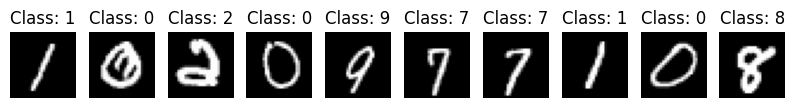

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [6]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week. 
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication. 

Note, like before, we consider multiple examples at once, adding another dimension to the input. 


 <img src="images/LinearModel_1.png"  align="center"/>
 


The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. 

We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

Let's make two changes that make more sense for classification:
- Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
- Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

In [7]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this time we're switching to cross entropy since it's classification.  

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step. 

In [8]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01)


LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn, print_info=False):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    #correct /= size
    accuracy = 100*correct / size

    if print_info:
        print(f'Loss = {loss:.4e}')
        print(f'Accuracy = {accuracy:.2f} %')
        print(f'{int(correct)} correct results out of {size} cases')
    return accuracy, loss

In [11]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.2886109270652135, accuracy: 91.95625
Epoch 1: training loss: 0.27211303915580115, accuracy: 92.45
Epoch 2: training loss: 0.2644747184912364, accuracy: 92.65416666666667
Epoch 3: training loss: 0.2596548239390055, accuracy: 92.775
Epoch 4: training loss: 0.25613255842526755, accuracy: 92.9
CPU times: user 20.8 s, sys: 44.1 s, total: 1min 4s
Wall time: 13 s


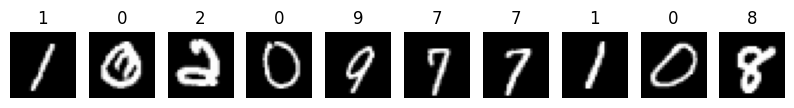

In [12]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc. 

# Inference

For a better measure of the quality of the model, let's see the model accuracy for the validation data.



In [13]:
acc_val, loss_val = evaluate(val_dataloader, linear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.2862, validation accuracy: 92.09%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [14]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    plt.close('all')
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    plt.figure(figsize=(maxtoshow, 1))
    ii = 0
    iters = iter(dataloader)
    while ii < maxtoshow:
        batch = next(iters)
        predictions = model(batch[0])
    
        rounded = predictions.argmax(1)
        errors = rounded!=batch[1]
        for i in range(batch[0].shape[0]):
            if ii>=maxtoshow:
                break
            if errors[i]:
                plt.subplot(1, maxtoshow, ii+1)
                plt.axis('off')
                plt.imshow(batch[0][i,0,:,:], cmap="gray")
                plt.title("%d (%d)" % (rounded[i], batch[1][i]))
                ii = ii + 1
    plt.show()

Here are the first 10 images from the validation data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


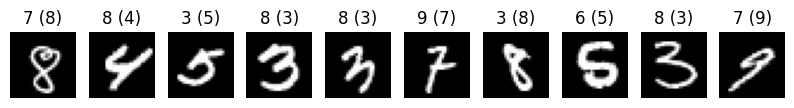

In [15]:
show_failures(linear_model, val_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn.png"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>

To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [16]:
class NonlinearClassifier(nn.Module):

    def __init__(self, act_fn=nn.ReLU(), nhidden=50):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, nhidden),
            act_fn,
            #nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(nhidden, nhidden),
            #nn.ReLU(),
            act_fn,
            #nn.Dropout(0.2),
            nn.Linear(nhidden, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

# Homework: train a Nonlinear Classifier

1. Write some code to train the NonlinearClassifier.
2. Create a data loader for the test data and check your model's accuracy on the test data. 

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

# JupyterHub Reminder

From [Homework 0](https://github.com/argonne-lcf/ai-science-training-series/blob/main/00_introToAlcf/02_jupyterNotebooks.md): "If you simply close your browser window, or logout without shutting down the jupyter server, your job will continue to occupy the worker node. Be considerate and shutdown your job when you finish."

File --> Hub Control Panel --> Stop my server

In [17]:
# Test data
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [18]:
def train(dataloader, model, loss_fn, optimizer, nepochs):
    for j in range(nepochs):
        train_one_epoch(dataloader, model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        print(f'Epoch {j}:')
        evaluate(dataloader, model, loss_fn, print_info=True)
        print()


def train_and_validate(model, optimizer, label, nepochs):

    print('#' * 79)
    print(label)
    print('#' * 79)
    train(train_dataloader, model, loss_fn, optimizer, nepochs)
    print('Validation data:')
    evaluate(val_dataloader, model, loss_fn, print_info=True)
    show_failures(model, val_dataloader, maxtoshow=20)
    print()
    print('Test data:')
    acc_val, loss_val = evaluate(test_dataloader, model, loss_fn, print_info=True)
    show_failures(model, test_dataloader, maxtoshow=20)
    print('=' * 79)
    return acc_val, loss_val


In [19]:
def compare_results(labels, acc_vals, loss_vals):
    print()
    print('#' * 79)
    for i, label in enumerate(labels):
        print(f'{i+1}: {label}')
        print(f'  accuracy = {acc_vals[i]:.2f} %, loss = {loss_vals[i]:.4e}')
    print('=' * 79)
    print()


###############################################################################
Model: lr = 1.0000e-02, optimizer = Adam, activation fn = ReLU, nhidden = 50
###############################################################################
Epoch 0:
Loss = 1.3967e-01
Accuracy = 95.79 %
45980 correct results out of 48000 cases

Epoch 1:
Loss = 1.2387e-01
Accuracy = 96.14 %
46145 correct results out of 48000 cases

Epoch 2:
Loss = 1.1256e-01
Accuracy = 96.59 %
46365 correct results out of 48000 cases

Epoch 3:
Loss = 9.8394e-02
Accuracy = 96.91 %
46515 correct results out of 48000 cases

Epoch 4:
Loss = 9.3485e-02
Accuracy = 97.13 %
46621 correct results out of 48000 cases

Epoch 5:
Loss = 7.9371e-02
Accuracy = 97.42 %
46764 correct results out of 48000 cases

Epoch 6:
Loss = 6.5948e-02
Accuracy = 97.98 %
47032 correct results out of 48000 cases

Epoch 7:
Loss = 6.9083e-02
Accuracy = 97.82 %
46953 correct results out of 48000 cases

Epoch 8:
Loss = 6.3374e-02
Accuracy = 98.05 %
47065 correct

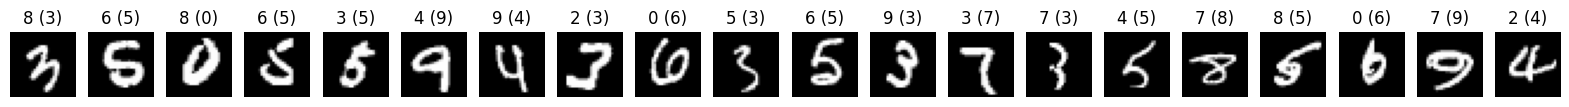


Test data:
Loss = 1.7403e-01
Accuracy = 96.12 %
9612 correct results out of 10000 cases
Showing max 20 first failures. The predicted class is shown first and the correct class in parentheses.


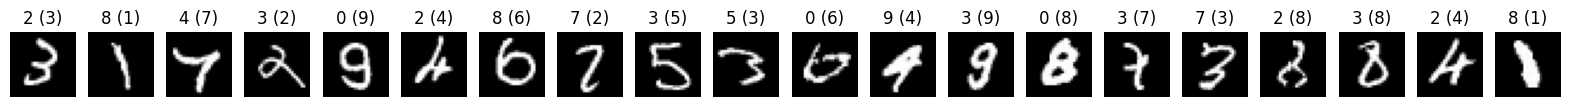

###############################################################################
Model: lr = 1.0000e-02, optimizer = SGD, activation fn = ReLU, nhidden = 50
###############################################################################
Epoch 0:
Loss = 2.0803e+00
Accuracy = 55.98 %
26869 correct results out of 48000 cases

Epoch 1:
Loss = 1.1325e+00
Accuracy = 75.49 %
36235 correct results out of 48000 cases

Epoch 2:
Loss = 6.7671e-01
Accuracy = 83.04 %
39860 correct results out of 48000 cases

Epoch 3:
Loss = 5.2920e-01
Accuracy = 85.95 %
41258 correct results out of 48000 cases

Epoch 4:
Loss = 4.5845e-01
Accuracy = 87.50 %
42000 correct results out of 48000 cases

Epoch 5:
Loss = 4.1756e-01
Accuracy = 88.54 %
42499 correct results out of 48000 cases

Epoch 6:
Loss = 3.9027e-01
Accuracy = 89.22 %
42826 correct results out of 48000 cases

Epoch 7:
Loss = 3.7004e-01
Accuracy = 89.76 %
43085 correct results out of 48000 cases

Epoch 8:
Loss = 3.5401e-01
Accuracy = 90.16 %
43275 correct 

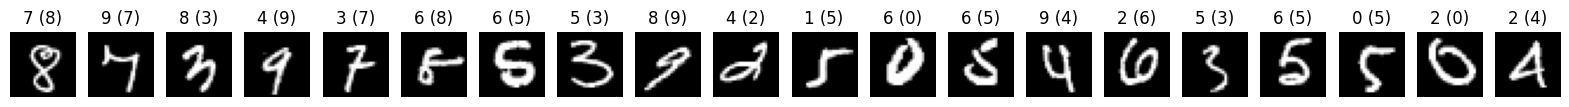


Test data:
Loss = 3.2639e-01
Accuracy = 90.58 %
9058 correct results out of 10000 cases
Showing max 20 first failures. The predicted class is shown first and the correct class in parentheses.


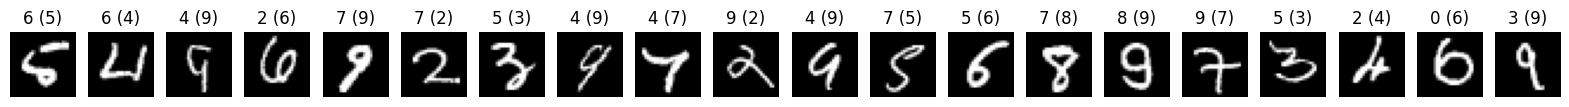

###############################################################################
Model: lr = 5.0000e-02, optimizer = Adam, activation fn = ReLU, nhidden = 50
###############################################################################
Epoch 0:
Loss = 3.0627e-01
Accuracy = 91.70 %
44014 correct results out of 48000 cases

Epoch 1:
Loss = 2.4150e-01
Accuracy = 93.78 %
45014 correct results out of 48000 cases

Epoch 2:
Loss = 2.5013e-01
Accuracy = 93.68 %
44966 correct results out of 48000 cases

Epoch 3:
Loss = 2.2563e-01
Accuracy = 94.25 %
45241 correct results out of 48000 cases

Epoch 4:
Loss = 2.4331e-01
Accuracy = 93.96 %
45102 correct results out of 48000 cases

Epoch 5:
Loss = 2.4241e-01
Accuracy = 93.90 %
45070 correct results out of 48000 cases

Epoch 6:
Loss = 2.3415e-01
Accuracy = 94.35 %
45288 correct results out of 48000 cases

Epoch 7:
Loss = 2.7508e-01
Accuracy = 93.92 %
45081 correct results out of 48000 cases

Epoch 8:
Loss = 2.3125e-01
Accuracy = 94.48 %
45350 correct

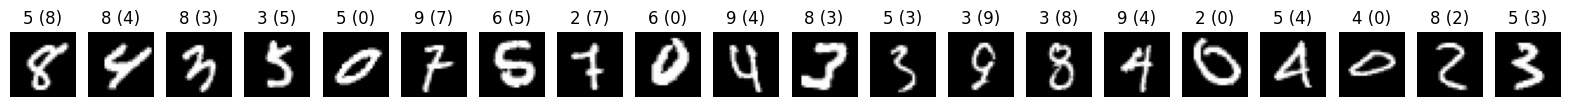


Test data:
Loss = 3.1447e-01
Accuracy = 92.72 %
9272 correct results out of 10000 cases
Showing max 20 first failures. The predicted class is shown first and the correct class in parentheses.


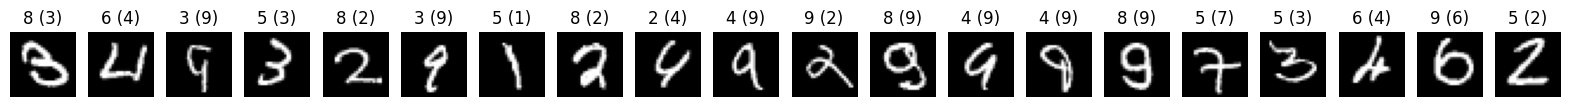

###############################################################################
Model: lr = 5.0000e-03, optimizer = Adam, activation fn = ReLU, nhidden = 50
###############################################################################
Epoch 0:
Loss = 1.7131e-01
Accuracy = 94.91 %
45556 correct results out of 48000 cases

Epoch 1:
Loss = 1.2098e-01
Accuracy = 96.33 %
46236 correct results out of 48000 cases

Epoch 2:
Loss = 9.7437e-02
Accuracy = 96.92 %
46522 correct results out of 48000 cases

Epoch 3:
Loss = 9.3059e-02
Accuracy = 96.96 %
46540 correct results out of 48000 cases

Epoch 4:
Loss = 6.9236e-02
Accuracy = 97.82 %
46955 correct results out of 48000 cases

Epoch 5:
Loss = 5.8764e-02
Accuracy = 98.09 %
47081 correct results out of 48000 cases

Epoch 6:
Loss = 6.0955e-02
Accuracy = 98.06 %
47071 correct results out of 48000 cases

Epoch 7:
Loss = 7.0967e-02
Accuracy = 97.74 %
46913 correct results out of 48000 cases

Epoch 8:
Loss = 7.3497e-02
Accuracy = 97.72 %
46905 correct

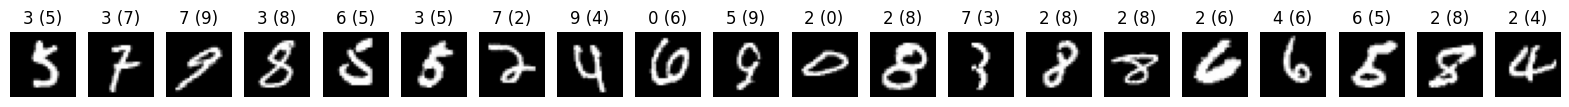


Test data:
Loss = 1.6352e-01
Accuracy = 96.18 %
9618 correct results out of 10000 cases
Showing max 20 first failures. The predicted class is shown first and the correct class in parentheses.


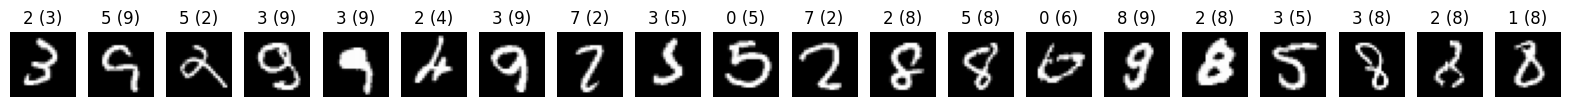

###############################################################################
Model: lr = 1.0000e-02, optimizer = Adam, activation fn = ReLU, nhidden = 20
###############################################################################
Epoch 0:
Loss = 2.1095e-01
Accuracy = 93.69 %
44969 correct results out of 48000 cases

Epoch 1:
Loss = 1.6753e-01
Accuracy = 95.02 %
45610 correct results out of 48000 cases

Epoch 2:
Loss = 1.4161e-01
Accuracy = 95.87 %
46017 correct results out of 48000 cases

Epoch 3:
Loss = 1.2562e-01
Accuracy = 96.15 %
46152 correct results out of 48000 cases

Epoch 4:
Loss = 1.3256e-01
Accuracy = 95.92 %
46041 correct results out of 48000 cases

Epoch 5:
Loss = 1.3902e-01
Accuracy = 95.72 %
45944 correct results out of 48000 cases

Epoch 6:
Loss = 1.2458e-01
Accuracy = 96.15 %
46150 correct results out of 48000 cases

Epoch 7:
Loss = 1.0730e-01
Accuracy = 96.72 %
46425 correct results out of 48000 cases

Epoch 8:
Loss = 1.0752e-01
Accuracy = 96.69 %
46410 correct

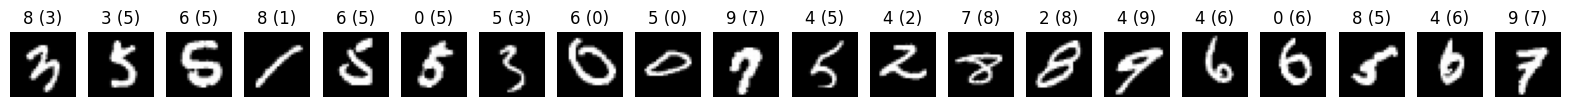


Test data:
Loss = 1.7390e-01
Accuracy = 95.34 %
9534 correct results out of 10000 cases
Showing max 20 first failures. The predicted class is shown first and the correct class in parentheses.


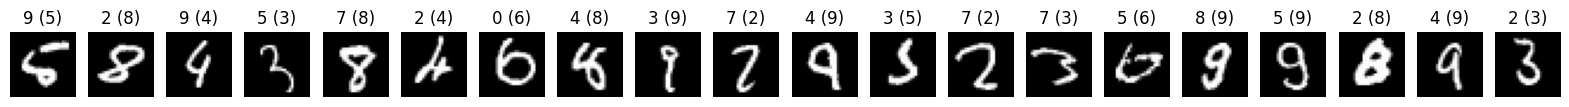

###############################################################################
Model: lr = 1.0000e-02, optimizer = Adam, activation fn = ReLU, nhidden = 80
###############################################################################
Epoch 0:
Loss = 1.2493e-01
Accuracy = 96.17 %
46162 correct results out of 48000 cases

Epoch 1:
Loss = 1.0362e-01
Accuracy = 96.75 %
46442 correct results out of 48000 cases

Epoch 2:
Loss = 8.8753e-02
Accuracy = 97.25 %
46682 correct results out of 48000 cases

Epoch 3:
Loss = 8.5327e-02
Accuracy = 97.30 %
46704 correct results out of 48000 cases

Epoch 4:
Loss = 5.9778e-02
Accuracy = 98.21 %
47141 correct results out of 48000 cases

Epoch 5:
Loss = 6.4649e-02
Accuracy = 97.97 %
47024 correct results out of 48000 cases

Epoch 6:
Loss = 5.2829e-02
Accuracy = 98.40 %
47230 correct results out of 48000 cases

Epoch 7:
Loss = 5.6325e-02
Accuracy = 98.22 %
47147 correct results out of 48000 cases

Epoch 8:
Loss = 4.6736e-02
Accuracy = 98.53 %
47295 correct

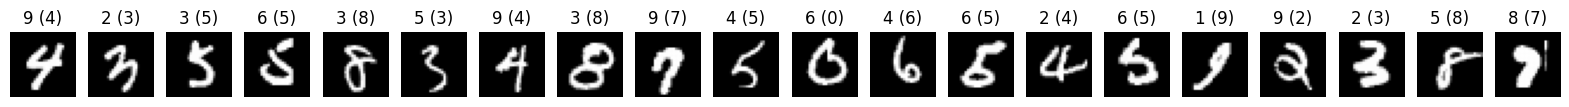


Test data:
Loss = 1.7014e-01
Accuracy = 96.88 %
9688 correct results out of 10000 cases
Showing max 20 first failures. The predicted class is shown first and the correct class in parentheses.


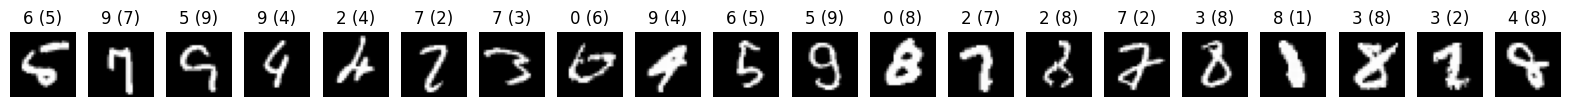

###############################################################################
Model: lr = 1.0000e-02, optimizer = Adam, activation fn = LeakyReLU, nhidden = 50
###############################################################################
Epoch 0:
Loss = 1.4088e-01
Accuracy = 95.65 %
45914 correct results out of 48000 cases

Epoch 1:
Loss = 1.0482e-01
Accuracy = 96.70 %
46418 correct results out of 48000 cases

Epoch 2:
Loss = 8.4547e-02
Accuracy = 97.35 %
46730 correct results out of 48000 cases

Epoch 3:
Loss = 7.5235e-02
Accuracy = 97.63 %
46864 correct results out of 48000 cases

Epoch 4:
Loss = 9.3019e-02
Accuracy = 97.26 %
46685 correct results out of 48000 cases

Epoch 5:
Loss = 6.6334e-02
Accuracy = 97.91 %
46995 correct results out of 48000 cases

Epoch 6:
Loss = 6.7908e-02
Accuracy = 97.89 %
46989 correct results out of 48000 cases

Epoch 7:
Loss = 7.2845e-02
Accuracy = 97.81 %
46949 correct results out of 48000 cases

Epoch 8:
Loss = 7.4949e-02
Accuracy = 97.85 %
46968 co

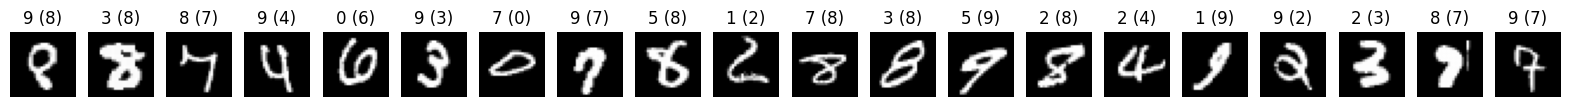


Test data:
Loss = 1.4665e-01
Accuracy = 96.87 %
9687 correct results out of 10000 cases
Showing max 20 first failures. The predicted class is shown first and the correct class in parentheses.


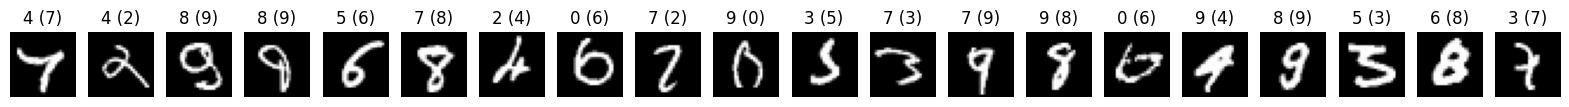

###############################################################################
Model: lr = 1.0000e-02, optimizer = Adam, activation fn = Sigmoid, nhidden = 50
###############################################################################
Epoch 0:
Loss = 1.6612e-01
Accuracy = 95.18 %
45688 correct results out of 48000 cases

Epoch 1:
Loss = 1.2209e-01
Accuracy = 96.35 %
46250 correct results out of 48000 cases

Epoch 2:
Loss = 9.9440e-02
Accuracy = 96.96 %
46540 correct results out of 48000 cases

Epoch 3:
Loss = 9.3259e-02
Accuracy = 97.06 %
46588 correct results out of 48000 cases

Epoch 4:
Loss = 8.9708e-02
Accuracy = 97.17 %
46640 correct results out of 48000 cases

Epoch 5:
Loss = 6.7939e-02
Accuracy = 97.85 %
46968 correct results out of 48000 cases

Epoch 6:
Loss = 5.6809e-02
Accuracy = 98.27 %
47168 correct results out of 48000 cases

Epoch 7:
Loss = 5.4327e-02
Accuracy = 98.18 %
47127 correct results out of 48000 cases

Epoch 8:
Loss = 4.6209e-02
Accuracy = 98.54 %
47298 corr

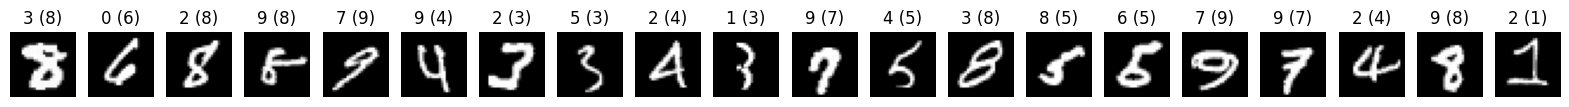


Test data:
Loss = 1.5206e-01
Accuracy = 95.94 %
9594 correct results out of 10000 cases
Showing max 20 first failures. The predicted class is shown first and the correct class in parentheses.


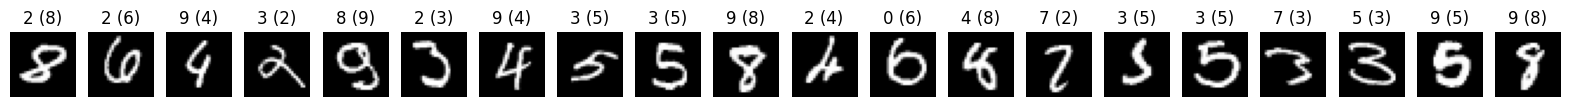


###############################################################################
1: Model: lr = 1.0000e-02, optimizer = Adam, activation fn = ReLU, nhidden = 50
  accuracy = 96.12 %, loss = 1.7403e-01
2: Model: lr = 1.0000e-02, optimizer = SGD, activation fn = ReLU, nhidden = 50
  accuracy = 90.58 %, loss = 3.2639e-01
3: Model: lr = 5.0000e-02, optimizer = Adam, activation fn = ReLU, nhidden = 50
  accuracy = 92.72 %, loss = 3.1447e-01
4: Model: lr = 5.0000e-03, optimizer = Adam, activation fn = ReLU, nhidden = 50
  accuracy = 96.18 %, loss = 1.6352e-01
5: Model: lr = 1.0000e-02, optimizer = Adam, activation fn = ReLU, nhidden = 20
  accuracy = 95.34 %, loss = 1.7390e-01
6: Model: lr = 1.0000e-02, optimizer = Adam, activation fn = ReLU, nhidden = 80
  accuracy = 96.88 %, loss = 1.7014e-01
7: Model: lr = 1.0000e-02, optimizer = Adam, activation fn = LeakyReLU, nhidden = 50
  accuracy = 96.87 %, loss = 1.4665e-01
8: Model: lr = 1.0000e-02, optimizer = Adam, activation fn = Sigmoid, nhidd

In [20]:
# ==============================================================================
# Train and test different models
# ==============================================================================
# Here, I train and compare several different nonlinear models.
# At the end of the output, there is a table that summarizes the results from different models.
# The choice of Adam optimizer over SGD has a large impact (~6 %), otherwise
# the resulting accuracy for the test data is rather insensitive to the tested choices of the size of the 
# hidden layer and activation function.
 
loss_fn = nn.CrossEntropyLoss()
nepochs = 10

labels = []
acc_vals = []
loss_vals = []

# model 1
lr = 1e-2
act_fn = nn.ReLU()
nhidden = 50
nonlinear_model = NonlinearClassifier(act_fn=act_fn, nhidden=nhidden)
optimizer = torch.optim.Adam(nonlinear_model.parameters(), lr=lr)
label = f'Model: lr = {lr:.4e}, optimizer = Adam, activation fn = ReLU, nhidden = {nhidden}'
labels.append(label)
acc_val, loss_val = train_and_validate(nonlinear_model, optimizer, label, nepochs)
acc_vals.append(acc_val)
loss_vals.append(loss_val)

# model 2
lr = 1e-2
act_fn = nn.ReLU()
nhidden = 50
nonlinear_model = NonlinearClassifier(act_fn=act_fn, nhidden=nhidden)
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=lr)
label = f'Model: lr = {lr:.4e}, optimizer = SGD, activation fn = ReLU, nhidden = {nhidden}'
labels.append(label)
acc_val, loss_val = train_and_validate(nonlinear_model, optimizer, label, nepochs)
acc_vals.append(acc_val)
loss_vals.append(loss_val)

# model 3
lr = 5e-2
act_fn = nn.ReLU()
nhidden = 50
nonlinear_model = NonlinearClassifier(act_fn=act_fn, nhidden=nhidden)
optimizer = torch.optim.Adam(nonlinear_model.parameters(), lr=lr)
label = f'Model: lr = {lr:.4e}, optimizer = Adam, activation fn = ReLU, nhidden = {nhidden}'
labels.append(label)
acc_val, loss_val = train_and_validate(nonlinear_model, optimizer, label, nepochs)
acc_vals.append(acc_val)
loss_vals.append(loss_val)

# model 4
lr = 5e-3
act_fn = nn.ReLU()
nhidden = 50
nonlinear_model = NonlinearClassifier(act_fn=act_fn, nhidden=nhidden)
optimizer = torch.optim.Adam(nonlinear_model.parameters(), lr=lr)
label = f'Model: lr = {lr:.4e}, optimizer = Adam, activation fn = ReLU, nhidden = {nhidden}'
labels.append(label)
acc_val, loss_val = train_and_validate(nonlinear_model, optimizer, label, nepochs)
acc_vals.append(acc_val)
loss_vals.append(loss_val)

# model 5
lr = 1e-2
act_fn = nn.ReLU()
nhidden = 20
nonlinear_model = NonlinearClassifier(act_fn=act_fn, nhidden=nhidden)
optimizer = torch.optim.Adam(nonlinear_model.parameters(), lr=lr)
label = f'Model: lr = {lr:.4e}, optimizer = Adam, activation fn = ReLU, nhidden = {nhidden}'
labels.append(label)
acc_val, loss_val = train_and_validate(nonlinear_model, optimizer, label, nepochs)
acc_vals.append(acc_val)
loss_vals.append(loss_val)

# model 6
lr = 1e-2
act_fn = nn.ReLU()
nhidden = 80
nonlinear_model = NonlinearClassifier(act_fn=act_fn, nhidden=nhidden)
optimizer = torch.optim.Adam(nonlinear_model.parameters(), lr=lr)
label = f'Model: lr = {lr:.4e}, optimizer = Adam, activation fn = ReLU, nhidden = {nhidden}'
labels.append(label)
acc_val, loss_val = train_and_validate(nonlinear_model, optimizer, label, nepochs)
acc_vals.append(acc_val)
loss_vals.append(loss_val)

# model 7
lr = 1e-2
act_fn = nn.LeakyReLU()
nhidden = 50
nonlinear_model = NonlinearClassifier(act_fn=act_fn, nhidden=nhidden)
optimizer = torch.optim.Adam(nonlinear_model.parameters(), lr=lr)
label = f'Model: lr = {lr:.4e}, optimizer = Adam, activation fn = LeakyReLU, nhidden = {nhidden}'
labels.append(label)
acc_val, loss_val = train_and_validate(nonlinear_model, optimizer, label, nepochs)
acc_vals.append(acc_val)
loss_vals.append(loss_val)

# model 8
lr = 1e-2
act_fn = nn.Sigmoid()
nhidden = 50
nonlinear_model = NonlinearClassifier(act_fn=act_fn, nhidden=nhidden)
optimizer = torch.optim.Adam(nonlinear_model.parameters(), lr=lr)
label = f'Model: lr = {lr:.4e}, optimizer = Adam, activation fn = Sigmoid, nhidden = {nhidden}'
labels.append(label)
acc_val, loss_val = train_and_validate(nonlinear_model, optimizer, label, nepochs)
acc_vals.append(acc_val)
loss_vals.append(loss_val)


# compare models
compare_results(labels, acc_vals, loss_vals)

